In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt



# Load Our Data

In [2]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
 shakespeare_text = f.read()


1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Text_Vectorization

In [4]:
text_vetc_layer=tf.keras.layers.TextVectorization(standardize='lower_and_strip_punctuation',split='character')
text_vetc_layer.adapt(shakespeare_text)

In [5]:
text_vetc_layer(shakespeare_text)

<tf.Tensor: shape=(1060997,), dtype=int64, numpy=array([20,  7, 10, ..., 11, 21, 12])>

In [6]:
char_count=text_vetc_layer.vocabulary_size()
char_count

31

In [7]:
encoder=text_vetc_layer(shakespeare_text)

In [8]:
len(encoder)

1060997

In [9]:
encoder

<tf.Tensor: shape=(1060997,), dtype=int64, numpy=array([20,  7, 10, ..., 11, 21, 12])>

Text(0, 0.5, 'Encoder Output Of 100 Characters')

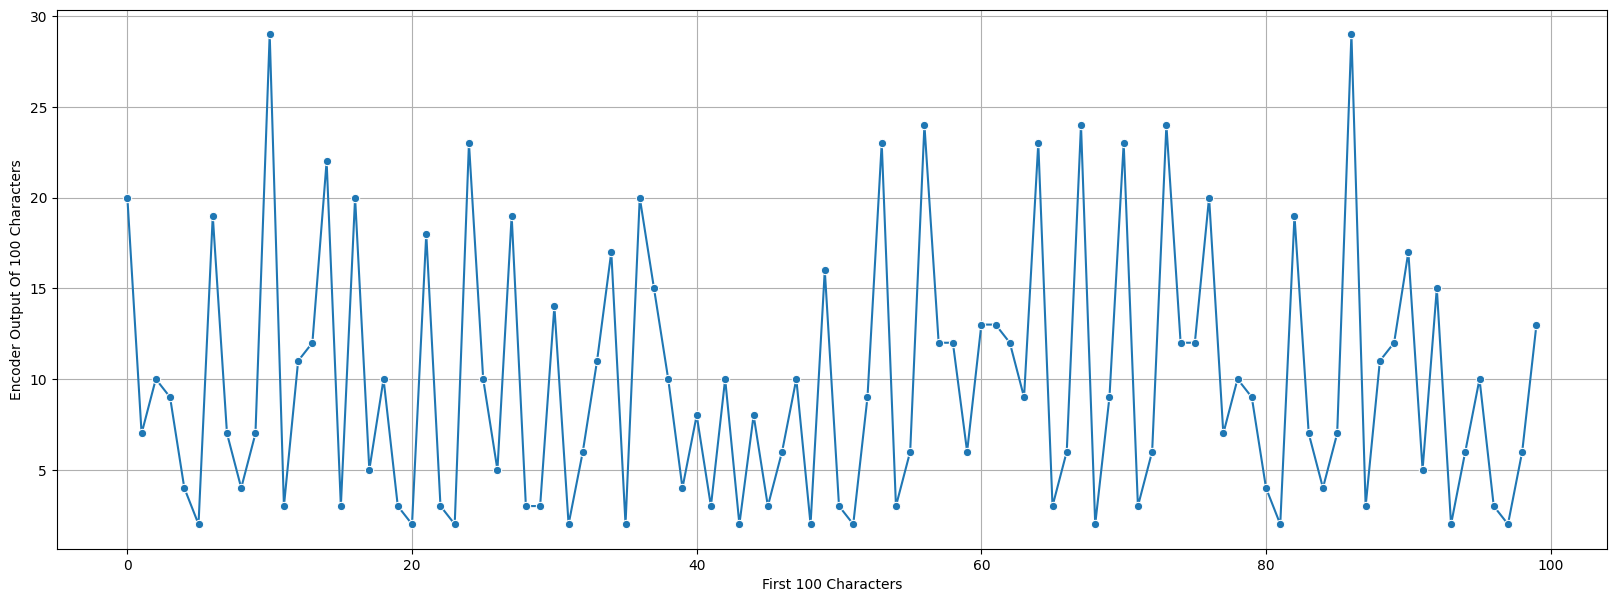

In [10]:
plt.figure(figsize=(20,7))
sns.lineplot(encoder[:100],marker='o')
plt.grid(True)
plt.xlabel('First 100 Characters')
plt.ylabel('Encoder Output Of 100 Characters')

In [11]:
encoder[:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([20,  7, 10,  9,  4,  2, 19,  7,  4,  7, 29,  3, 11, 12, 22,  3, 20,
        5, 10,  3,  2, 18,  3,  2, 23, 10,  5, 19,  3,  3, 14,  2,  6, 11,
       17,  2, 20, 15, 10,  4,  8,  3, 10,  2,  8,  3,  6, 10,  2, 16,  3,
        2,  9, 23,  3,  6, 24, 12, 12,  6, 13, 13, 12,  9, 23,  3,  6, 24,
        2,  9, 23,  3,  6, 24, 12, 12, 20,  7, 10,  9,  4,  2, 19,  7,  4,
        7, 29,  3, 11, 12, 17,  5, 15,  2,  6, 10,  3,  2,  6, 13])>

In [12]:
print(shakespeare_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# Now Let's Create Our Dataset.

Our dataset will consist of windows of length ... with targets of the same length.

In [13]:
def make_dataset(data,window_size,batch_size=32,shuffle=False,win_shift=1):
  data=tf.data.Dataset.from_tensor_slices(data)
  win_data=data.window(size=window_size+1,shift=win_shift,drop_remainder=True)
  win_data=win_data.flat_map(lambda win:win.batch(window_size+1))
  if shuffle==True:
    win_data.shuffle(1000)
  win_data=win_data.batch(batch_size=batch_size)
  return win_data.map(lambda win: (win[:,:-1], win[:,1:])).prefetch(1)


* I will use 90% for Train and 10% for Validation

In [14]:
train_len=int(len(encoder)*0.9)
train_set=make_dataset(encoder[:train_len],window_size=100).repeat()
valid_set=make_dataset(encoder[train_len:],window_size=100)

In [15]:
list(train_set.take(1))

[(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
  array([[20,  7, 10, ...,  2,  6, 13],
         [ 7, 10,  9, ...,  6, 13, 13],
         [10,  9,  4, ..., 13, 13,  2],
         ...,
         [ 3, 14,  2, ...,  8,  6, 11],
         [14,  2,  6, ...,  6, 11,  2],
         [ 2,  6, 11, ..., 11,  2,  4]])>,
  <tf.Tensor: shape=(32, 100), dtype=int64, numpy=
  array([[ 7, 10,  9, ...,  6, 13, 13],
         [10,  9,  4, ..., 13, 13,  2],
         [ 9,  4,  2, ..., 13,  2, 10],
         ...,
         [14,  2,  6, ...,  6, 11,  2],
         [ 2,  6, 11, ..., 11,  2,  4],
         [ 6, 11, 17, ...,  2,  4,  5]])>)]

In [16]:
train_set.element_spec

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

# Model_1

In [ ]:
model_1=tf.keras.Sequential([])
model_1.add(tf.keras.layers.Input(shape=[None]))
model_1.add(tf.keras.layers.Embedding(input_dim=char_count,output_dim=10)),
model_1.add(tf.keras.layers.Conv1D(36, kernel_size=2, padding="causal", activation="relu")),
model_1.add(tf.keras.layers.BatchNormalization())
for rate in(2,4,6):
  model_1.add(tf.keras.layers.Conv1D(filters=rate*26,padding='causal',kernel_size=2,activation='relu',dilation_rate=rate)),
  model_1.add(tf.keras.layers.BatchNormalization()),
model_1.add(tf.keras.layers.GRU(256,return_sequences=True)),
model_1.add(tf.keras.layers.LSTM(256,return_sequences=True)),
model_1.add(tf.keras.layers.Dense(char_count,activation='softmax'))
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 10)       │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, None, 36)       │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, None, 36)       │           144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, None, 52)       │         3,796 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, None, 52)       │           208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, None, 104)      │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, None, 104)      │           416 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, None, 156)      │        32,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, None, 156)      │           624 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 256)      │       317,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 256)      │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 31)       │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901,009 (3.44 MB)

 Trainable params: 900,313 (3.43 MB)

 Non-trainable params: 696 (2.72 KB)

In [ ]:
def lr_schedule_exp(epoch):
  if epoch<5:
    return float(tf.exp(-epoch/10.)*0.001)/2
  else:
    return 0.0001/5
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_1.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

In [ ]:
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(),metrics=["accuracy"])
history_1=model_1.fit(train_set, epochs=7, validation_data=valid_set,callbacks=[learning_rate_callback,checkpoint],steps_per_epoch=29838)

Epoch 1/7
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4911 - loss: 1.6674
Epoch 1: val_accuracy improved from -inf to 0.49490, saving model to model_1.keras
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 767s 25ms/step - accuracy: 0.4911 - loss: 1.6674 - val_accuracy: 0.4949 - val_loss: 1.6344 - learning_rate: 5.0000e-04
Epoch 2/7
    1/29838 ━━━━━━━━━━━━━━━━━━━━ 11:48 24ms/step - accuracy: 0.5103 - loss: 1.5452

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


29836/29838 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5656 - loss: 1.3746
Epoch 2: val_accuracy improved from 0.49490 to 0.51032, saving model to model_1.keras
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 802s 27ms/step - accuracy: 0.5656 - loss: 1.3746 - val_accuracy: 0.5103 - val_loss: 1.5813 - learning_rate: 4.5242e-04
Epoch 3/7
29836/29838 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5764 - loss: 1.3315
Epoch 3: val_accuracy improved from 0.51032 to 0.52045, saving model to model_1.keras
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 802s 27ms/step - accuracy: 0.5764 - loss: 1.3315 - val_accuracy: 0.5205 - val_loss: 1.5528 - learning_rate: 4.0937e-04
Epoch 4/7
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5833 - loss: 1.3049
Epoch 4: val_accuracy improved from 0.52045 to 0.52834, saving model to model_1.keras
29838/29838 ━━━━━━━━━━━━━━━━━━━━ 802s 27ms/step - accuracy: 0.5833 - loss: 1.3049 - val_accuracy: 0.5283 - val_loss: 1.5299 - learning_rate: 3.7041e-04
Epoch 5/7
29838/29838 ━━━━

In [ ]:
model_1.evaluate(valid_set)

3313/3313 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5614 - loss: 1.4103


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[1.4852190017700195, 0.5453346371650696]

* Second Run

In [18]:
model_1=tf.keras.models.load_model('Model_Sh.keras')


In [20]:
def lr_schedule_exp(epoch):
    return float(tf.exp(-epoch/10.)*0.001)/2
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_1.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

In [21]:
history_1=model_1.fit(train_set, initial_epoch=7,epochs=18, validation_data=valid_set,callbacks=[learning_rate_callback,checkpoint],steps_per_epoch=29837)

Epoch 8/18
29836/29837 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6027 - loss: 1.2338
Epoch 8: val_accuracy improved from -inf to 0.54129, saving model to model_1.keras
29837/29837 ━━━━━━━━━━━━━━━━━━━━ 772s 26ms/step - accuracy: 0.6027 - loss: 1.2338 - val_accuracy: 0.5413 - val_loss: 1.4945 - learning_rate: 2.4829e-04
Epoch 9/18


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


29836/29837 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6060 - loss: 1.2236
Epoch 9: val_accuracy improved from 0.54129 to 0.54319, saving model to model_1.keras
29837/29837 ━━━━━━━━━━━━━━━━━━━━ 804s 27ms/step - accuracy: 0.6060 - loss: 1.2236 - val_accuracy: 0.5432 - val_loss: 1.4939 - learning_rate: 2.2466e-04
Epoch 10/18
29836/29837 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6118 - loss: 1.2021
Epoch 10: val_accuracy improved from 0.54319 to 0.54639, saving model to model_1.keras
29837/29837 ━━━━━━━━━━━━━━━━━━━━ 801s 27ms/step - accuracy: 0.6118 - loss: 1.2021 - val_accuracy: 0.5464 - val_loss: 1.4839 - learning_rate: 2.0328e-04
Epoch 11/18
29837/29837 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6188 - loss: 1.1796
Epoch 11: val_accuracy improved from 0.54639 to 0.54817, saving model to model_1.keras
29837/29837 ━━━━━━━━━━━━━━━━━━━━ 802s 27ms/step - accuracy: 0.6188 - loss: 1.1796 - val_accuracy: 0.5482 - val_loss: 1.4801 - learning_rate: 1.8394e-04
Epoch 12/18
29836/29

In [22]:
model_1.save('Model_Sh_run2.keras')

* Trd Run

In [ ]:
model_1=tf.keras.models.load_model('Model_Sh.keras')

In [ ]:
def lr_schedule_exp(epoch):
    return float(tf.exp(-epoch/10.)*0.001)/2
learning_rate_callback=tf.keras.callbacks.LearningRateScheduler(lr_schedule_exp)
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_1.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)

In [ ]:
history_1=model_1.fit(train_set, initial_epoch=7,epochs=18, validation_data=valid_set,callbacks=[learning_rate_callback,checkpoint],steps_per_epoch=29837)


# Using The Model_1 To Create Shakespearean Text

In [ ]:
model_1.save('Model_Sh.keras')

In [ ]:
Model_Sh=tf.keras.Sequential([
    text_vetc_layer,
    model_1
])

* Let's test our Model_Sh

In [ ]:
text_vetc_layer('hi')

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([8, 7])>

In [ ]:
y_pred_prob=Model_Sh.predict(tf.constant(['to be or not ']))[0,-1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
y_pred=tf.argmax(y_pred_prob)

In [ ]:
y_pred

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [ ]:
print(text_vetc_layer.get_vocabulary()[y_pred])

t


* Function to predict the next character

In [ ]:
def next_char_prediction(text,model,temp=1):
  y_pred_prob=model.predict(tf.constant([text]))[0,-1]
  logits=tf.math.log([y_pred_prob])/temp
  y_pred=tf.random.categorical(logits=logits,num_samples=1)[0,0]
  return text_vetc_layer.get_vocabulary()[y_pred]

* Function to predict the next n_characters

In [ ]:
def predict_text(text,n_chars,model,temp=1):
  for _ in range(n_chars):
    text+=next_char_prediction(text,model,temp)
  return text

In [ ]:
predict_text('The d',n_chars=3,model=Model_Sh,temp=0.01)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


'The duke'

In [ ]:
predict_text('Let us kill ',n_chars=7,model=Model_Sh,temp=0.001)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


'Let us kill the sta'